<a href="https://colab.research.google.com/github/yvanminyem/whyzzerRec/blob/main/Copie_de_deep_recommenders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Building deep retrieval models

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/recommenders/examples/deep_recommenders"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/recommenders/blob/main/docs/examples/deep_recommenders.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/recommenders/blob/main/docs/examples/deep_recommenders.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/recommenders/docs/examples/deep_recommenders.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Preliminaries

We first import the necessary packages.

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 85 kB 2.5 MB/s 
     |████████████████████████████████| 4.0 MB 5.0 MB/s 


In [ ]:
import os
import tempfile

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

plt.style.use('seaborn-whitegrid')

Loading the data and splitting into train and test

In [ ]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"],
})
movies = movies.map(lambda x: x["movie_title"])

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.


We also do some housekeeping to prepare feature vocabularies.

In [ ]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_id"]))))

## Model definition

In [ ]:
class UserModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])
    self.timestamp_embedding = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
    ])
    self.normalized_timestamp = tf.keras.layers.experimental.preprocessing.Normalization()

    self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["timestamp"]),
        self.normalized_timestamp(inputs["timestamp"]),
    ], axis=1)

Now adding layers

In [ ]:
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, layer_sizes):
    """Model for encoding user queries.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # We first use the user model for generating embeddings.
    self.embedding_model = UserModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

The `layer_sizes` parameter gives us the depth and width of the model. We can vary it to experiment with shallower or deeper models.

### Candidate model




In [ ]:
class MovieModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=unique_movie_titles,mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(movies)

  def call(self, titles):
    return tf.concat([
        self.title_embedding(titles),
        self.title_text_embedding(titles),
    ], axis=1)

And expand it with hidden layers:

In [ ]:
class CandidateModel(tf.keras.Model):
  """Model for encoding movies."""

  def __init__(self, layer_sizes):
    """Model for encoding movies.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    self.embedding_model = MovieModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

### Combined model

With both `QueryModel` and `CandidateModel` defined, we can put together a combined model and implement our loss and metrics logic. To make things simple, we'll enforce that the model structure is the same across the query and candidate models.

In [ ]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, layer_sizes):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "timestamp": features["timestamp"],
    })
    movie_embeddings = self.candidate_model(features["movie_title"])

    return self.task(
        query_embeddings, movie_embeddings, compute_metrics=not training)

## Training the model

### Prepare the data

We first split the data into a training set and a testing set.

In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

### Shallow model

We're ready to try out our first, shallow, model!

In [ ]:
num_epochs = 300

model = MovielensModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Top-100 accuracy: 0.27.


This gives us a top-100 accuracy of around 0.27. We can use this as a reference point for evaluating deeper models.



In [ ]:
model = MovielensModel([64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

two_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.29.


The accuracy here is 0.29, quite a bit better than the shallow model.

We can plot the validation accuracy curves to illustrate this:

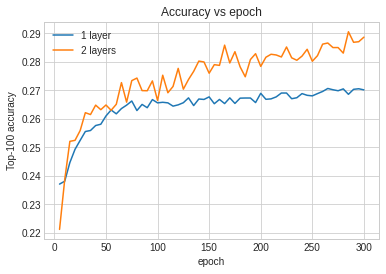

In [ ]:
num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()